# Introduction

This notebook contains my attempts to use the Surprise library to build a book recommendation system through a process called collaborative filtering. 

## Prerequisites
Before diving into building a recommendation system using the Surprise library, it's important to have some familiarity with Python programming and data manipulation techniques. Additionally, a basic understanding of collaborative filtering and recommendation systems is helpful. However I did try to provide explainations where I thought necessary. 

## Collaborative Filtering
Collaborative filtering is a technique used in recommendation systems that involves predicting a user's preferences based on the preferences of other users who have similar behavior or preferences. It involves finding similarities between users or items based on their interactions with the system.

### Content-based Filtering
To be clear, this notebook does not implement content-based filtering. However, it is worth knowing the difference between the two. Both approaches have their advantages and disadvantages and are often used together to build more effective recommendation systems.

Content-based filtering is a technique that recommends items similar to those that a user has liked in the past based on the content of the items. It uses information about the attributes or features of items, such as the genre, author, or plot summary of a book, to identify other items that are similar in content.

The main difference between collaborative filtering and content-based filtering is the type of data used to make recommendations. Collaborative filtering relies on user interactions and preferences, while content-based filtering relies on item attributes and features. Both approaches have their advantages and disadvantages and are often used together to build more effective recommendation systems.

## Surprise
Surprise is a Python library designed for building and analyzing recommender systems. It provides a range of algorithms for collaborative filtering, including matrix factorization-based methods, k-NN, and SVD. Surprise does not provide algorithms for content-based filtering. 

## The Data
In this notebook, I used a dataset containing information about books and their ratings from the Goodreads website. The dataset contains information such as book title, author, and user ratings. You will gain a better understanding of the data in the EDA section. 



# Installs and imports


The code begins by installing the "surprise" package using the pip package manager. It then imports several modules, including "files" and "os" from the "google.colab" package, and "pandas", "matplotlib.pyplot", and "defaultdict" from their respective packages. The "drive" module is imported from "google.colab" and used to mount the user's Google Drive to the current Python environment. Finally, several modules are imported from the "surprise" package, including "Dataset", "Reader", "SVD", "accuracy", "KNNBaseline", and "get_dataset_dir", as well as "train_test_split" from the "surprise.model_selection" subpackage. These modules provide tools for building and evaluating recommender systems.

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195798 sha256=1fb9da7478d87e0f7e745013049444f26a88cdc1d866a42eaa1fa37aeed2dd72
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [ ]:
# Mount your Google Drive
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import networkx as nx
from collections import defaultdict
from surprise import Dataset, Reader, SVD, accuracy, KNNBaseline, get_dataset_dir
from surprise.model_selection import train_test_split

# EDA

Exploratory Data Analysis (EDA) is a critical step in data analysis that involves examining and visualizing data to gain insights and discover patterns, trends, relationships, anomalies, and other important characteristics of the data. I find it useful in familiarizingmyself with the dataset. 

In [ ]:
# Load the ratings data in panda dataframe
ratings_df = pd.read_csv('ratings.csv')

# Load the books data in panda dataframe
books_df = pd.read_csv('books.csv')

In [ ]:
print(ratings_df.head())

   book_id  user_id  rating
0        1      314       5
1        1      439       3
2        1      588       5
3        1     1169       4
4        1     1185       4


In [ ]:
# set display options
pd.set_option('display.max_columns', None) # display all columns
pd.set_option('display.width', 1000) # set display width

print(books_df.head())

   id  book_id  best_book_id  work_id  books_count       isbn        isbn13                      authors  original_publication_year                            original_title                                              title language_code  average_rating  ratings_count  work_ratings_count  work_text_reviews_count  ratings_1  ratings_2  ratings_3  ratings_4  ratings_5                                          image_url                                    small_image_url
0   1  2767052       2767052  2792775          272  439023483  9.780439e+12              Suzanne Collins                     2008.0                          The Hunger Games            The Hunger Games (The Hunger Games, #1)           eng            4.34        4780653             4942365                   155254      66715     127936     560092    1481305    2706317  https://images.gr-assets.com/books/1447303603m...  https://images.gr-assets.com/books/1447303603s...
1   2        3             3  4640799          491  4395

In [ ]:
# Print dataset size and examine column data types
print("Number of ratings: ", len(ratings_df))
print(ratings_df.info())

Number of ratings:  981756
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB
None


In [ ]:
print("Number of books: ", len(books_df))
print(ratings_df.info())

Number of books:  10000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB
None


In [ ]:
# Check for missing values in the dataframe
ratings_df.isnull().sum()

book_id    0
user_id    0
rating     0
dtype: int64

In [ ]:
# Distribution of ratings
print(ratings_df['rating'].value_counts())

4    357366
5    292961
3    248623
2     63231
1     19575
Name: rating, dtype: int64


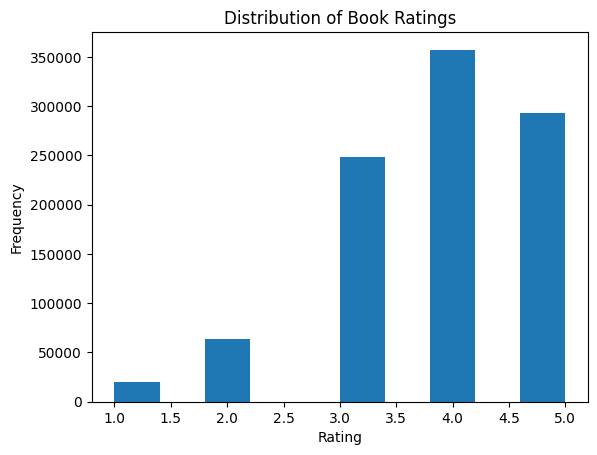

In [ ]:
# Create a histogram of the ratings
plt.hist(ratings_df['rating'])
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Book Ratings')
plt.show()

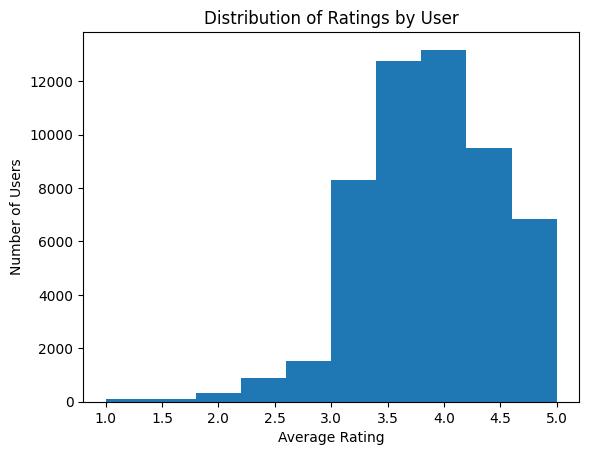

In [ ]:
import matplotlib.pyplot as plt

# Group the data by user ID and calculate the mean rating for each user
user_ratings = ratings_df.groupby('user_id')['rating'].mean()

# Plot a histogram of the user ratings
plt.hist(user_ratings, bins=10)
plt.title('Distribution of Ratings by User')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.show()

In [ ]:
ratings_df['rating'].describe()

count    981756.000000
mean          3.856534
std           0.983941
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [ ]:
ratings_df.groupby('book_id')['rating'].mean()

book_id
1        4.240000
2        4.210000
3        3.090000
4        4.460000
5        3.890000
           ...   
9996     3.969388
9997     4.426966
9998     4.326316
9999     3.727273
10000    4.000000
Name: rating, Length: 10000, dtype: float64

In [ ]:
ratings_df.corr()

,book_id,user_id,rating
book_id,1.000000,0.044033,0.016714
user_id,0.044033,1.000000,0.087472
rating,0.016714,0.087472,1.000000


This following code performs two important data preprocessing tasks. Firstly, it merges two dataframes (ratings_df and books_df) on a common column 'book_id' using the pd.merge function from the pandas library. The merged dataframe contains all the columns from the two dataframes, combined based on the common 'book_id' column. This allows us to analyze the data more comprehensively and get a more holistic view of the relationships between the variables.

Secondly, the code drops several unnecessary columns from the merged dataframe. These columns are not required for the specific analysis or modeling task at hand and therefore can be safely removed.

In [ ]:
# Merge the two dataframes on 'book_id'
merged_df = pd.merge(ratings_df, books_df, on='book_id')

# drop unnecessary columns
merged_df.drop(['language_code', 'average_rating', 'ratings_count', 'work_ratings_count',
                 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4',
                 'ratings_5', 'original_title', 'isbn13', 'id', 'best_book_id', 'work_id',
                 'books_count', 'small_image_url'], axis=1, inplace=True)

In [ ]:
print(merged_df.head())

   book_id  user_id  rating       isbn                      authors  original_publication_year                                              title                                          image_url
0        1      314       5  439785960  J.K. Rowling, Mary GrandPré                     2005.0  Harry Potter and the Half-Blood Prince (Harry ...  https://images.gr-assets.com/books/1361039191m...
1        1      439       3  439785960  J.K. Rowling, Mary GrandPré                     2005.0  Harry Potter and the Half-Blood Prince (Harry ...  https://images.gr-assets.com/books/1361039191m...
2        1      588       5  439785960  J.K. Rowling, Mary GrandPré                     2005.0  Harry Potter and the Half-Blood Prince (Harry ...  https://images.gr-assets.com/books/1361039191m...
3        1     1169       4  439785960  J.K. Rowling, Mary GrandPré                     2005.0  Harry Potter and the Half-Blood Prince (Harry ...  https://images.gr-assets.com/books/1361039191m...
4        1     

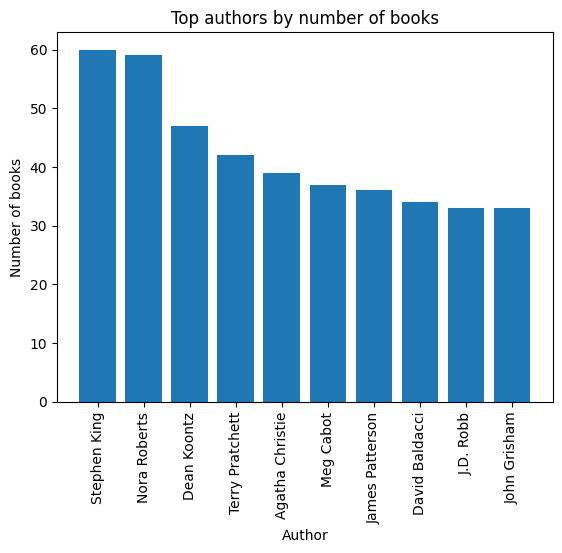

In [ ]:
# Count the number of books by each author
author_counts = books_df['authors'].value_counts()

# Get the top 10 authors by the number of books
top_authors = author_counts.head(10)

# Plot a bar chart of the top authors
plt.bar(top_authors.index, top_authors.values)
plt.xticks(rotation=90)
plt.xlabel('Author')
plt.ylabel('Number of books')
plt.title('Top authors by number of books')
plt.show()

Wordcloud is a Python library used for generating visual representations of text data. It is particularly useful for creating word clouds, which are visualizations that represent the most frequent words in a text document or corpus as larger and bolder words.

This code generates a word cloud of the book titles in the merged_df dataframe. The resulting plot shows a visual representation of the most common words in the book titles, with the size of each word representing its frequency.

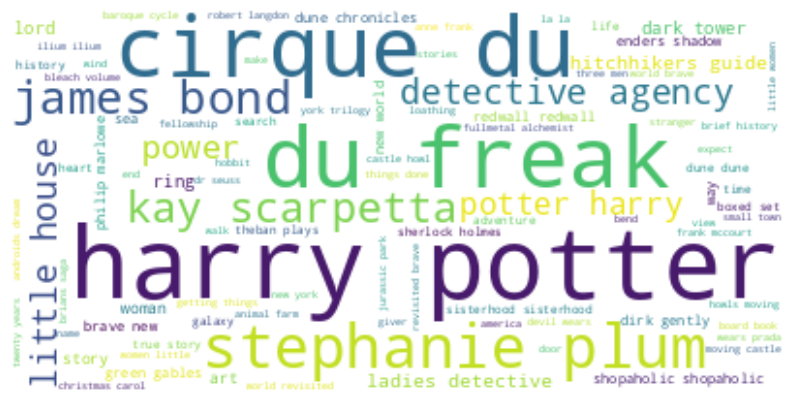

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import re

# Combine all the book titles into a single string
text = ' '.join(merged_df['title'].astype(str))

# Preprocess the text data
processed_text = re.sub(r'[^\w\s]', '', text.lower())
processed_text = re.sub(r'[^\w\s]', '', processed_text)
processed_text = re.sub('\s+', ' ', processed_text)


# Create a word cloud
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(processed_text)

# Plot the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The book-book co-occurrence network is a powerful tool for understanding the relationships between books based on how often they are read by the same user. The network consists of nodes and edges, where each node represents a book, and an edge between two nodes indicates that these two books were read by the same user. The thickness of the line between two nodes represents the co-occurrence frequency, which is a measure of how often the two books were read together by the same user. In other words, if a user has rated one book, the likelihood of finding the other book in the same section is higher.

This network can provide valuable insights into which books are commonly read together and can be used for various purposes, such as book recommendations or identifying similar books. For example, if two books have a high co-occurrence frequency, it may suggest that they are similar in terms of genre, writing style, or subject matter, and may be recommended to users who have read one of these books.

In the example provided, the dataframe was filtered to include only the first 1000 books published after the year 2000.

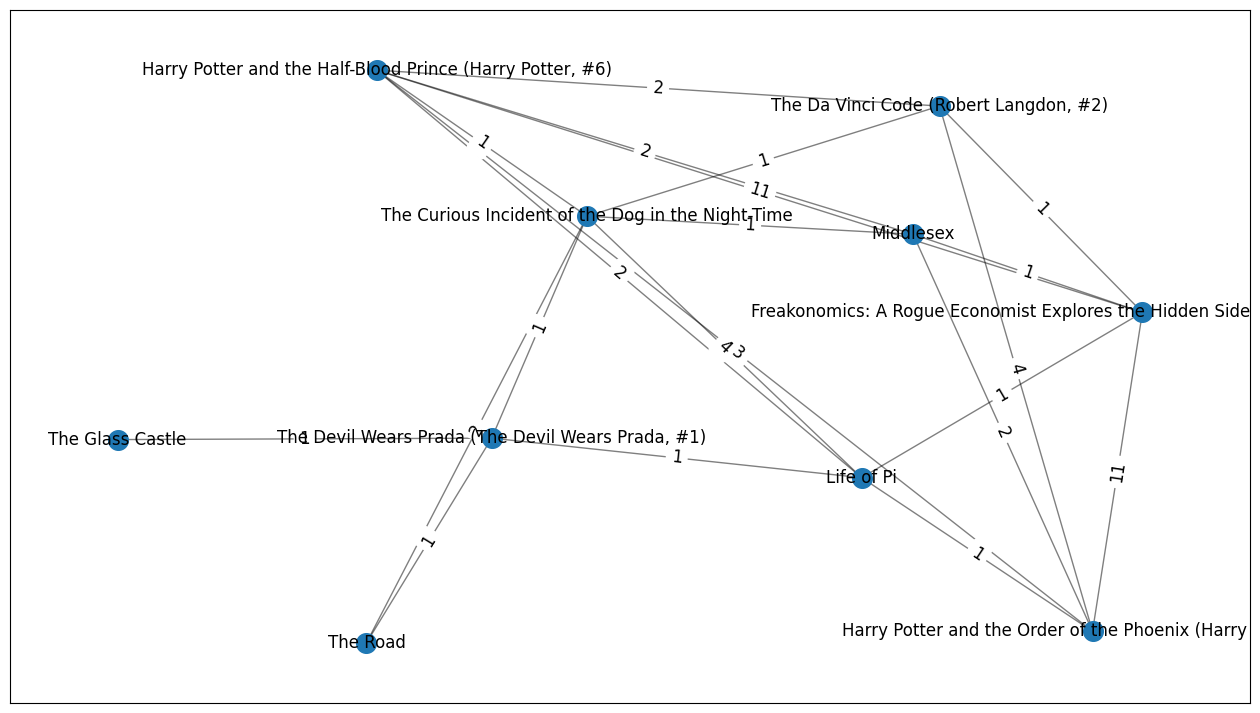

In [ ]:
# Filter the data to books published after 2000
network_df = merged_df[merged_df['original_publication_year'] > 2000]
network_df = network_df[:1000]
# Create a co-occurrence matrix
books = network_df['title'].unique()

co_occurrence = pd.DataFrame(index=books, columns=books).fillna(0)

for user in network_df['user_id'].unique():
    titles = network_df[network_df['user_id'] == user]['title'].unique()
    for i in range(len(titles)):
        for j in range(i+1, len(titles)):
            co_occurrence.loc[titles[i], titles[j]] += 1
            co_occurrence.loc[titles[j], titles[i]] += 1

# Create a networkx graph
G = nx.from_pandas_adjacency(co_occurrence)

# Plot the graph
# pos = nx.spring_layout(G, k=0.5)
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(16, 9))

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=200)

# Draw the edges with labels for frequency of co-occurrence
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

# Draw the node labels
node_labels = {book: book for book in books}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)

plt.show()

# Build the Model

Alright, now that we are more familiar with the data we can train a prediction model and build our recommendation system!


In [ ]:
# Take a subset of the merged_df so it runs faster
subset = merged_df.sample(n=50000, random_state=42)

# Define the reader object for Surprise
reader = Reader(rating_scale=(1, 5))

# Load the merged dataframe into Surprise's Dataset object
data = Dataset.load_from_df(subset[['user_id', 'book_id', 'rating']], reader)

# Split the dataset
trainset, testset = train_test_split(data, test_size=0.2)

# Instantiate the algorithm
algo = SVD()

# Train the model
algo.fit(trainset)

The following function [get_top_n](https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user) was provided in the surprise documentation. 

In [ ]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Using the [build_anti_testset](https://surprise.readthedocs.io/en/stable/trainset.html?highlight=build_anti_testset#surprise.Trainset.build_anti_testset) method from surprise, we build a test set of books users have not rated. 


In [ ]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

**What is RMSE?**

RMSE stands for Root Mean Squared Error. It is a metric commonly used to evaluate the accuracy of a predictive model, particularly in regression analysis. RMSE measures the difference between the actual values and the predicted values of a variable, taking into account the square of the differences.

A lower RMSE indicates a better fit of the model to the data, as it means that the difference between the actual and predicted values is smaller.

In [ ]:
rmse = accuracy.rmse(predictions)

RMSE: 0.3366


In [ ]:
predictions[:5]

[Prediction(uid=1053, iid=667, r_ui=3.860925, est=4.0424556493920685, details={'was_impossible': False}),
 Prediction(uid=1053, iid=7520, r_ui=3.860925, est=3.726350250655737, details={'was_impossible': False}),
 Prediction(uid=1053, iid=6538, r_ui=3.860925, est=4.016802966681521, details={'was_impossible': False}),
 Prediction(uid=1053, iid=7981, r_ui=3.860925, est=4.031254801552204, details={'was_impossible': False}),
 Prediction(uid=1053, iid=7763, r_ui=3.860925, est=3.717256644644928, details={'was_impossible': False})]

While it's certainly interesting to know the book ID, it may not be the most helpful recommendation on its own. So, let's jazz things up a bit and create a user-friendly map to help you easily locate and print the titles of those recommended books!

In [ ]:
# Map book_id to book title
id_to_title = dict(zip(merged_df['book_id'], merged_df['title']))

In [ ]:
# Print the first 5 items in id_to_title
count = 0
for book_id, book_title in id_to_title.items():
    print(f'{book_id}: {book_title}')
    count += 1
    if count == 5:
        break

1: Harry Potter and the Half-Blood Prince (Harry Potter, #6)
2: Harry Potter and the Order of the Phoenix (Harry Potter, #5)
3: Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
5: Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)
6: Harry Potter and the Goblet of Fire (Harry Potter, #4)


In [ ]:
# Print the recommended items for each user
for uid, user_ratings in list(top_n.items())[:5]:
    print(uid, [iid for (iid, _) in user_ratings])

1053 [9566, 2767, 6862, 4708, 8172, 9531, 7081, 3885, 2865, 9912]
7674 [9566, 7039, 1274, 3463, 4373, 7661, 8680, 7081, 3885, 1618]
16257 [4921, 9566, 7999, 2865, 2767, 8909, 9301, 3885, 9912, 2743]
41539 [9566, 2865, 7081, 4708, 250, 6862, 7039, 2767, 6613, 1618]
4827 [9566, 9301, 2865, 4708, 6862, 1618, 9712, 2767, 6613, 5346]


In [ ]:
# Print the recommended items and their rating estimations for 5 users
for uid, user_ratings in list(top_n.items())[:5]:
    print(f"Test subject {uid}, I have carefully considered your preferences. I believe you would like the following books:")
    for (iid, rating) in user_ratings:
        print("- {} (rating: {:.2f})".format(id_to_title[iid], rating))
    print()

Test subject 1053, I have carefully considered your preferences. I believe you would like the following books:
- Still Life with Woodpecker (rating: 4.84)
- A People's History of the United States (rating: 4.82)
- Amsterdam (rating: 4.74)
- The Beautiful and Damned (rating: 4.74)
- Superman: Birthright (rating: 4.69)
- Peter and the Shadow Thieves (Peter and the Starcatchers, #2) (rating: 4.69)
- The Android's Dream (rating: 4.69)
- The Taste of Home Cookbook (rating: 4.67)
- Girl with a Pearl Earring (rating: 4.66)
- The Rules of Attraction (rating: 4.65)

Test subject 7674, I have carefully considered your preferences. I believe you would like the following books:
- Still Life with Woodpecker (rating: 4.81)
- Tears of the Giraffe (No. 1 Ladies' Detective Agency, #2) (rating: 4.74)
- Men Are from Mars, Women Are from Venus (rating: 4.74)
- A Bend in the Road (rating: 4.64)
- First They Killed My Father: A Daughter of Cambodia Remembers (rating: 4.63)
- Next (rating: 4.63)
- Fierce Inv

As an attentive data analyst (and one that isn't always 100% sure whats going on), I wanted to double-check that the predicted ratings we're looking at are, in fact, the model's predictions, not the user's actual ratings.

To get started, simply run the cell and enter a user ID, and voila! You'll receive a list of the top 5 recommended books, complete with their predicted ratings for that user.

But we don't stop there! In the next cell, you'll find a delightful dataset containing the user's actual book ratings. That way, you can make a quick comparison and confirm that the predicted ratings are, indeed, for books they haven't already rated.

***feel free to correct me, and inform me of better methods***

In [ ]:
print("Choose a user id from above")
test_subject = int(input("input a user id: "))
print(f"Welcome, test subject {test_subject}")

Choose a user id from above
input a user id: 4827
Welcome, test subject 4827


In [ ]:
user_predictions = [pred for pred in predictions if pred.uid == test_subject]

print(f"Hello test subject {test_subject}, I calculated your you preferences based on your previous ratings. Here is a sample:")
for pred in user_predictions[:5]:
    item_id = pred.iid
    item_title = books_df.loc[books_df['book_id'] == item_id, 'title'].iloc[0]
    print(f"For item number {item_id}, titled '{item_title}' your predicted rating is", pred.est)

Hello test subject 4827, I calculated your you preferences based on your previous ratings. Here is a sample:
For item number 9417, titled 'Shopaholic and Sister (Shopaholic, #4)' your predicted rating is 4.045283159517341
For item number 667, titled 'Anthem' your predicted rating is 3.6844242329076207
For item number 7520, titled 'Path of the Assassin (Scot Harvath, #2)' your predicted rating is 3.503106319930965
For item number 6538, titled 'Portrait of a Killer: Jack the Ripper - Case Closed' your predicted rating is 3.7370066235160664
For item number 7763, titled 'The Joy Luck Club' your predicted rating is 3.558532344754541


In [ ]:
subset_df = merged_df[merged_df['user_id'] == test_subject]
print(f"test subject {test_subject}, these are your previously rated books: ")
print(subset_df[['title', 'rating']])

test subject 4827, these are your previously rated books: 
                                          title  rating
5503   City of Glass (The New York Trilogy, #1)       5
8707                            Of Mice and Men       5
12110                               The Odyssey       4
13505                 A Midsummer Night's Dream       4
19707                        Great Expectations       3
26103                    The Emperor's Children       3
39474                          Night Over Water       5
44963                                 Bleachers       5
49806                            V for Vendetta       3
67339            The Long Patrol (Redwall, #10)       3


This code takes user input for a book title and maps it to a corresponding book_id based on a list of available books' titles. The collaborative filtering algorithm is then used to fetch the prediction for the entered book_id and the current "test subject". Finally, the program prints the predicted rating the test subject would leave for the entered book title.

In [ ]:
# Get book_id from user input
book_title = input("Enter a book title: ")
while book_title not in id_to_title.values():
    print("Invalid book title. Please try again.")
    book_title = input("Enter a book title: ")
book_id = next(key for key, value in id_to_title.items() if value == book_title)

# Get prediction for book_id
prediction = algo.predict(test_subject, book_id)
print(f"Predicted rating for '{book_title}' by test subject {test_subject} is {prediction.est:.3f}")

Enter a book title: The Last Juror
Predicted rating for 'The Last Juror' by test subject 4827 is 4.429


# Precision and Recall

This code for calculating [precision and recall](https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-compute-precision-k-and-recall-k) is provided in the Surprise documentation. 

Precision measures the proportion of recommended items that are relevant to the user, while recall measures the proportion of relevant items that are recommended to the user. 

Precision and recall can be used to compare the effectiveness of different recommendation algorithms or to tune the parameters of a single algorithm.

I will show the code below for the calculation of precision and recall but I will not be tuning any parameters. That is out of the scope of this project. 

In [ ]:
from collections import defaultdict

from surprise import Dataset, SVD
from surprise.model_selection import KFold


def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [ ]:
books_df = pd.read_csv("books.csv")
ratings_df = pd.read_csv("ratings.csv")

# Merge the two dataframes on book_id
merged_df = pd.merge(books_df, ratings_df, on="book_id")
# drop unnecessary columns
merged_df.drop(['language_code', 'average_rating', 'ratings_count', 'work_ratings_count',
                 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4',
                 'ratings_5', 'original_title', 'isbn13', 'id', 'best_book_id', 'work_id',
                 'books_count', 'small_image_url'], axis=1, inplace=True)

# Define the reader object for Surprise
reader = Reader(rating_scale=(1, 5))

# Load the merged dataframe into Surprise's Dataset object
data = Dataset.load_from_df(merged_df[['user_id', 'book_id', 'rating']], reader)

kf = KFold(n_splits=5)
algo = SVD()

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)
    # Precision and recall can then be averaged over all users
    print("Precision: ", sum(prec for prec in precisions.values()) / len(precisions))
    print("Recall: ", sum(rec for rec in recalls.values()) / len(recalls))

79701
Precision:  0.33599079025549605
Recall:  0.308575354384178
Precision:  0.33475271876018603
Recall:  0.30886378612843185
Precision:  0.3334163184256543
Recall:  0.3090073755117767
Precision:  0.33264152609732406
Recall:  0.30669882483889366
Precision:  0.3327084641372918
Recall:  0.3071141336613577


#  k Nearest Neighbors

This code was provided in the surprise documentation to find the [k nearest Neighbors](https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-k-nearest-neighbors-of-a-user-or-item). I only slightly modified it for this specific use case. 

k-Nearest Neighbors (k-NN) is often used as a collaborative filtering technique. The algorithm finds the k most similar items (or users) to a given item (or user) based on their past interactions with the system (ratings). It then recommends items that those similar items (or users) have interacted with in a positive way.

The code provided is an implementation of k-NN algorithm for recommending books to users. It reads in a dataset of book ratings, trains a k-NN model on that data, and then recommends books to users based on the ratings of similar users.

In [ ]:
def read_item_names(merged_df):
    """Read book title and id from a csv file and return two dictionaries to
    convert raw ids into book titles and book titles into raw ids.
    """
    # Create dictionaries to convert raw ids into book titles and book titles
    # into raw ids
    rid_to_name = {}
    name_to_rid = {}
    for index, row in merged_df.iterrows():
        rid = str(row["book_id"])
        name = row["title"]
        rid_to_name[rid] = name
        name_to_rid[name] = rid

    return rid_to_name, name_to_rid

In [ ]:
# Load book title and id data from csv files
books_df = pd.read_csv("books.csv")
ratings_df = pd.read_csv("ratings.csv")

# Merge the two dataframes on book_id
merged_df = pd.merge(books_df, ratings_df, on="book_id")

# drop unnecessary columns
merged_df.drop(['language_code', 'average_rating', 'ratings_count', 'work_ratings_count',
                 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4',
                 'ratings_5', 'original_title', 'isbn13', 'id', 'best_book_id', 'work_id',
                 'books_count', 'small_image_url'], axis=1, inplace=True)

merged_df.to_csv('merged_df.csv', index=False)

# Define the reader object for Surprise
reader = Reader(rating_scale=(1, 5))

# Load the merged dataframe into Surprise's Dataset object
data = Dataset.load_from_df(merged_df[['user_id', 'book_id', 'rating']], reader)

trainset = data.build_full_trainset()
sim_options = {"name": "pearson_baseline", "user_based": False}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)
algo

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
print("Number of items in the trainset:", len(algo.trainset.all_items()))

Number of items in the trainset: 812


In [ ]:
# Read the mappings raw id <-> movie name
rid_to_name, name_to_rid = read_item_names(books_df)

In [ ]:
# Retrieve inner id of the book
book = input("Book title: ")

if books_df['title'].isin([book]).any():
    print(f"{book} is in books_df")
else:
    print(f"{book} is not in books_df")

raw_id = name_to_rid[book]
raw_id = int(raw_id)

inner_id = algo.trainset.to_inner_iid(raw_id)

neighbors_inner = algo.get_neighbors(inner_id, k=10)

# neighbors = []
# for neighbor_inner in neighbors_inner:
#     neighbor_raw = algo.trainset.to_raw_iid(neighbor_inner)
#     neighbor_name = rid_to_name[str(neighbor_raw)]
#     neighbors.append(neighbor_name) 

neighbors = []
for neighbor_inner in neighbors_inner:
    neighbor_raw = algo.trainset.to_raw_iid(neighbor_inner)
    if str(neighbor_raw) not in rid_to_name:
        continue
    neighbor_name = rid_to_name[str(neighbor_raw)]
    neighbors.append(neighbor_name)


print()
print(f"The 10 nearest neighbors to {book} are:")
for book in neighbors:
    print(book)

Book title: Great Expectations
Great Expectations is in books_df

The 10 nearest neighbors to Great Expectations are:
The Emperor's Children
V for Vendetta
The Long Patrol (Redwall, #10)
Veronika Decides to Die
Lysistrata
Play It as It Lays
Welcome to the Monkey House
The Secret Garden
The Long Goodbye (Philip Marlowe, #6)
Man's Search for Meaning


In [ ]:
# Retrieve inner id of the book
book_title = input("Book title: ")
raw_id = name_to_rid[book_title]
raw_id = int(raw_id)

inner_id = algo.trainset.to_inner_iid(raw_id)

neighbors_inner = algo.get_neighbors(inner_id, k=10)

# Get book information
book_data = merged_df.loc[merged_df['book_id'] == raw_id].iloc[0]

# Print book information and nearest neighbors
print()
print(f"Book title: {book_data['title']}")
print(f"Image URL: {book_data['image_url']}")
print(f"Authors: {book_data['authors']}")
print(f"Publication Year: {book_data['original_publication_year']}")
print()
print(f"The 10 nearest neighbors to {book_title} are:")
for neighbor_inner in neighbors_inner:
    neighbor_raw = algo.trainset.to_raw_iid(neighbor_inner)
    neighbor_name = rid_to_name[str(neighbor_raw)]
    neighbor_data = merged_df.loc[merged_df['book_id'] == neighbor_raw].iloc[0]
    print(f"Book title: {neighbor_data['title']}")
    print(f"Image URL: {neighbor_data['image_url']}")
    print(f"Authors: {neighbor_data['authors']}")
    print(f"Publication Year: {neighbor_data['original_publication_year']}")
    print()

Book title: Great Expectations

Book title: Great Expectations
Image URL: https://images.gr-assets.com/books/1327920219m/2623.jpg
Authors: Charles Dickens
Publication Year: 1860.0

The 10 nearest neighbors to Great Expectations are:
Book title: The Emperor's Children
Image URL: https://images.gr-assets.com/books/1320497348m/3648.jpg
Authors: Claire Messud
Publication Year: 2006.0

Book title: V for Vendetta
Image URL: https://images.gr-assets.com/books/1343668985m/5805.jpg
Authors: Alan Moore, David   Lloyd
Publication Year: 1990.0

Book title: The Long Patrol (Redwall, #10)
Image URL: https://s.gr-assets.com/assets/nophoto/book/111x148-bcc042a9c91a29c1d680899eff700a03.png
Authors: Brian Jacques, Allan Curless
Publication Year: 1997.0

Book title: Veronika Decides to Die
Image URL: https://s.gr-assets.com/assets/nophoto/book/111x148-bcc042a9c91a29c1d680899eff700a03.png
Authors: Paulo Coelho, Margaret Jull Costa
Publication Year: 1998.0

Book title: Lysistrata
Image URL: https://images.

# Save the Trained Model

One last bit of code that allows us to save the trained model to use later. 


In [ ]:
# Create a new directory in your drive
dir_name = 'kNN_book_recommender'
try:
    os.makedirs(f'/content/drive/My Drive/{dir_name}')
    print(f'Folder has been created with Name "{dir_name}" at "/content/drive/My Drive/{dir_name}".')
except FileExistsError:
    print(f'Folder with Name "{dir_name}" already exists.')

Folder has been created with Name "kNN_book_recommender" at "/content/drive/My Drive/kNN_book_recommender".


In [ ]:
from surprise import dump

algo = algo

# Save the model to your Google Drive
dump_file_path = '/content/drive/MyDrive/kNN_book_recommender/kNN_model.pkl'
dump.dump(dump_file_path, algo=algo)

# Conclusion

This notebook provides an introduction to the surprise library, but it does not cover all the functionalities of the library. There are many more features that you can explore and utilize with surprise.

While working on this project, I gained a lot of knowledge and experience. It took me multiple attempts to verify that everything was functioning correctly, and although I still have some doubts, I am pleased with my progress.

Overall, this project was enjoyable, and I plan to use surprise again in the future for other projects. 
